## Kiva Loan Funding - Modeling

**PURPOSE**: Predict which microfinance loans will be funded and how quickly they will be funded

**AUTHOR** : Maureen Wiebe

**DATA SOURCES**:<br> 
- Kiva Developer Tools: https://www.kiva.org/build/data-snapshots
    
**REV DATE**: 4-11-2020

In [55]:
import pandas as pd 
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pickle
plt.style.use('seaborn')
pd.set_option('max_columns', None)

### Import Data and Variables 

In [56]:
loans_2019 = pd.read_pickle('C:/Users/mwalz2/Documents/Python/Springboard/Kiva_Capstone_Project/data/interim/loans_2019_clean.pkl')

In [74]:
with open('trainingdata.pickle', 'rb') as f: 
    X, y, X_train, X_test, y_train, y_test,X_train_norm,X_test_norm, norm = pickle.load(f)

### Baseline Model 
For this particular problem the baseline methodology for comparing future models will be to assign the dominant class (funded) to all loans.  This will be helpful to see if any models can do a better job of identifying the imbalanced class(expired). 

In [ ]:
#Need to include metrics for evaluating baseline model of all funded 

### Random Forest Model 

In [79]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs=-1)

rf.fit(X_train_norm, y_train)

y_pred = rf.predict(X_test_norm)

In [99]:
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score,auc
from sklearn.metrics import plot_confusion_matrix

ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

print(classification_report(y_test, y_pred))

Random Forest: Accuracy=0.966
Random Forest: f1-score=0.957
              precision    recall  f1-score   support

           0       0.73      0.21      0.33      1261
           1       0.97      1.00      0.98     31211

    accuracy                           0.97     32472
   macro avg       0.85      0.61      0.66     32472
weighted avg       0.96      0.97      0.96     32472



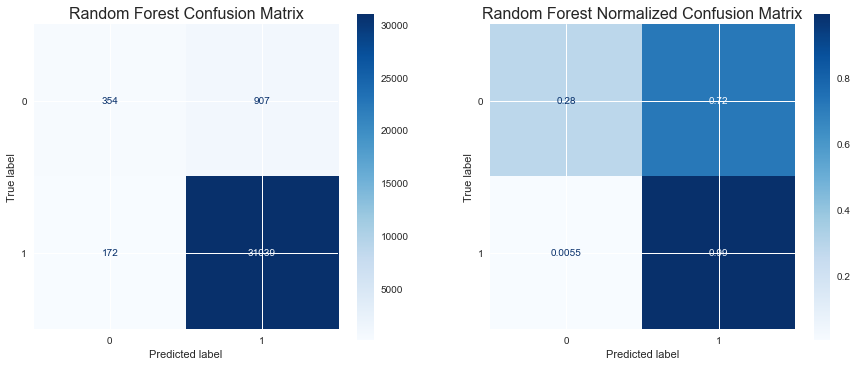

In [83]:
fig, (ax1, ax2) = plt.subplots(figsize = (15, 6), nrows = 1, ncols = 2)
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(rf,X_test_norm, y_test,cmap=plt.cm.Blues, ax=ax1)
plot_confusion_matrix(rf,X_test_norm, y_test,cmap=plt.cm.Blues, normalize='true',ax=ax2)
ax1.set_title('Random Forest Confusion Matrix', fontsize =16)
ax2.set_title('Random Forest Normalized Confusion Matrix', fontsize =16)
plt.show()

30


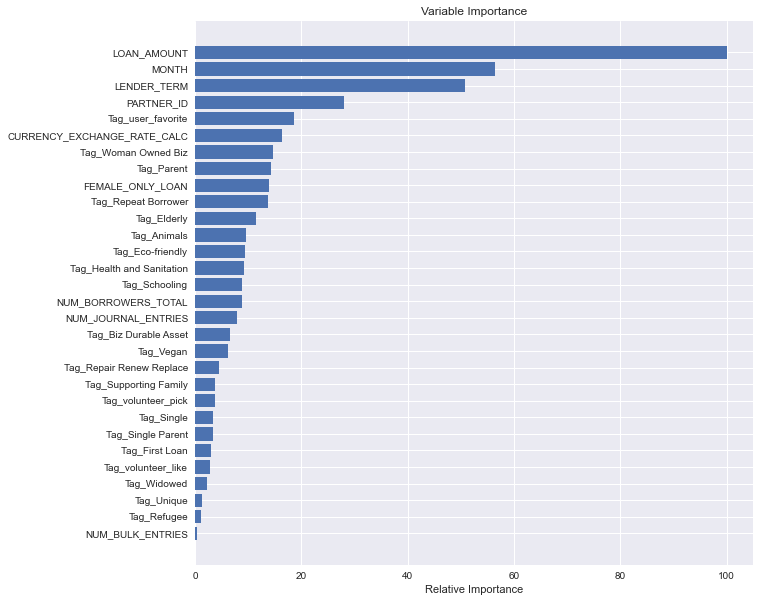

In [86]:

feature_importance = rf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### Hyperparameter Tuning
To explore if the results of the Random Forest model can be improved, I will use Random Search to optimize the model's hyperparameters.  

In [108]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', None]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)


# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth}

In [105]:
rf1 = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf1, param_distributions=random_grid, n_iter =25, cv=5, verbose=2, random_state = 42, n_jobs =-1
                              scoring = 'f1_macro' )

rf_random.fit(X_train_norm, y_train)

y_pred = rf_random.predict(X_test_norm)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


Based on the randomized search the optimal number of tree in the model is 733, the max features for each split will be the square root of the total number of features and each tree will have a maximum depth of 50 levels. This model's overall performace was similar to that of the untuned Random Forest model and did not improve the model's accuracy in predict which loans would not be funded(minority class).  

In [107]:
rf_random.best_params_

{'n_estimators': 733, 'max_features': 'auto', 'max_depth': 50}

In [106]:
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

print(classification_report(y_test, y_pred))

Random Forest: Accuracy=0.967
Random Forest: f1-score=0.960
              precision    recall  f1-score   support

           0       0.68      0.27      0.38      1261
           1       0.97      0.99      0.98     31211

    accuracy                           0.97     32472
   macro avg       0.82      0.63      0.68     32472
weighted avg       0.96      0.97      0.96     32472



In [111]:
cnf_matrix = confusion_matrix(y_test, y_pred)
print(cnf_matrix)

[[  337   924]
 [  161 31050]]


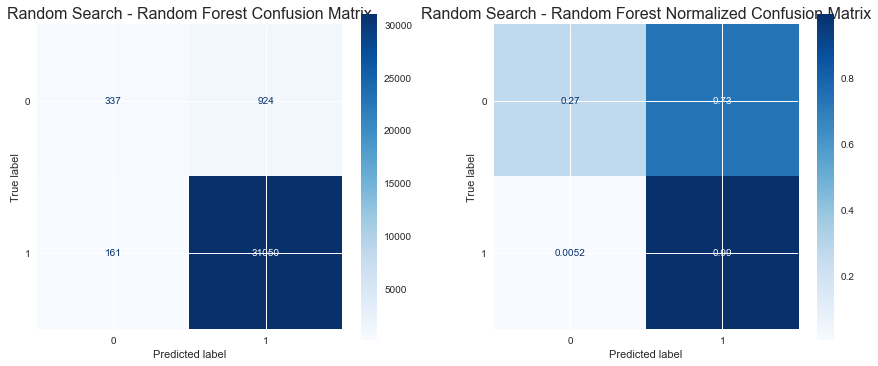

In [112]:
fig, (ax1, ax2) = plt.subplots(figsize = (15, 6), nrows = 1, ncols = 2)

plot_confusion_matrix(rf_random,X_test_norm, y_test,cmap=plt.cm.Blues, ax=ax1)
plot_confusion_matrix(rf_random,X_test_norm, y_test,cmap=plt.cm.Blues, normalize='true',ax=ax2)
ax1.set_title('Random Search - Random Forest Confusion Matrix', fontsize =16)
ax2.set_title('Random Search - Random Forest Normalized Confusion Matrix', fontsize =16)
plt.show()

### Logistic Regression Model

In [101]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logreg = LogisticRegression(max_iter = 1000)

logreg.fit(X_train_norm, y_train)

y_pred = logreg.predict(X_test_norm)

In [102]:
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')

print('Logistic Regression: Accuracy=%.3f' % (ac))

print('Logistic Regression: f1-score=%.3f' % (f1))

print(classification_report(y_test, y_pred))

Logistic Regression: Accuracy=0.962
Logistic Regression: f1-score=0.951
              precision    recall  f1-score   support

           0       0.56      0.14      0.22      1261
           1       0.97      1.00      0.98     31211

    accuracy                           0.96     32472
   macro avg       0.76      0.57      0.60     32472
weighted avg       0.95      0.96      0.95     32472



In [103]:
from sklearn.feature_selection import RFE

rfe = RFE(logreg, n_features_to_select= 45)
rfe = rfe.fit(X_train_norm, y_train)

print(rfe.support_)
print(rfe.ranking_)

C:\Users\mwalz2\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=45 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


[ True False  True  True  True  True False  True  True False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
  True False False False False False False False False False False False
  True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False  True  True False False False
 False False False  True False False False False False False  True False
 False False False False False False False False False False False False
 False False False False False False False False  True False False False
 False False False False False False False False Fa

In [128]:
importance = pd.DataFrame([X.columns,rfe.support_,rfe.ranking_],['Feature','Use','Rank']).T
importance[importance.Use == True]

,Feature,Use,Rank
0,LOAN_AMOUNT,True,1
2,CURRENCY_EXCHANGE_RATE_CALC,True,1
3,MONTH,True,1
4,LENDER_TERM,True,1
5,NUM_JOURNAL_ENTRIES,True,1
7,NUM_BORROWERS_TOTAL,True,1
8,FEMALE_ONLY_LOAN,True,1
36,Tag_Orphan,True,1
48,Activity_Beekeeping,True,1
115,Activity_Home Appliances,True,1


### SMOTE (Synthetic Minority Oversampling Technique)
+ Works by creating synthetic samples from the minor class (no-subscription) instead of creating copies.
+ Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observations.
https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3)

#fit the scaler to the train dataset 
norm = MinMaxScaler().fit(X_train)

#transform the train dataset 
X_train_norm = norm.transform(X_train)

#transform the test dataset based on the scaler fitted to the train dataset to prevent any data leakage
X_test_norm = norm.transform(X_test)

In [142]:
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state=42)

X_train_sm, y_train_sm = sm.fit_resample(X_train_norm, y_train)

print(X_train_norm.shape, X_train_sm.shape)

(75765, 338) (145856, 338)


In [145]:
rf_sm = RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs=-1)

rf_sm.fit(X_train_sm, y_train_sm)

y_pred = rf.predict(X_test_norm)

In [144]:
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')

print('SMOTE Random Forest: Accuracy=%.3f' % (ac))

print('SMOTE Random Forest: f1-score=%.3f' % (f1))

print(classification_report(y_test, y_pred))

Random Forest: Accuracy=0.964
Random Forest: f1-score=0.961
              precision    recall  f1-score   support

           0       0.53      0.39      0.45      1238
           1       0.98      0.99      0.98     31234

    accuracy                           0.96     32472
   macro avg       0.75      0.69      0.72     32472
weighted avg       0.96      0.96      0.96     32472



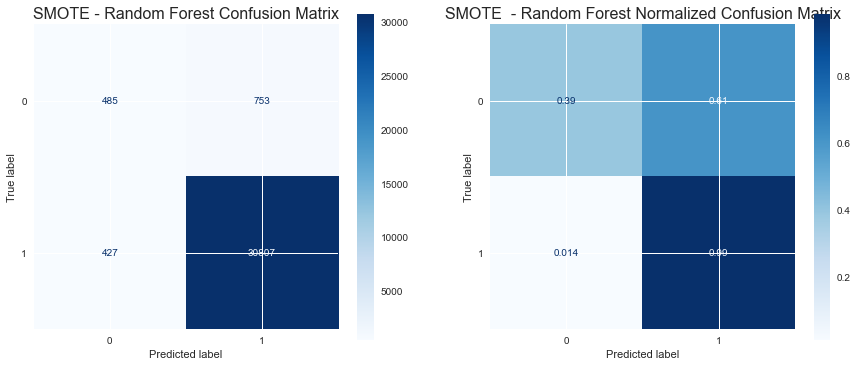

In [146]:
fig, (ax1, ax2) = plt.subplots(figsize = (15, 6), nrows = 1, ncols = 2)

plot_confusion_matrix(rf_sm,X_test_norm, y_test,cmap=plt.cm.Blues, ax=ax1)
plot_confusion_matrix(rf_sm,X_test_norm, y_test,cmap=plt.cm.Blues, normalize='true',ax=ax2)
ax1.set_title('SMOTE - Random Forest Confusion Matrix', fontsize =16)
ax2.set_title('SMOTE  - Random Forest Normalized Confusion Matrix', fontsize =16)
plt.show()

### SVM One-Class??